In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def apply_ekf_iteration(x_prev, P_prev, z, f_func, h_func, F_jacobian, H_jacobian, Q, R):
    # Predict
    x_pred = f_func(x_prev)
    F = F_jacobian(x_prev)
    P_pred = F @ P_prev @ F.T + Q

    # Update
    H = H_jacobian(x_pred)
    y_pred = h_func(x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ (z - y_pred)
    P_upd = (np.eye(len(P_prev)) - K @ H) @ P_pred

    return x_upd, P_upd


In [3]:
# Parameters
num_measurements = 1200
dT = 0.01
param_amp = 1.0
param_ang_freq = 10.0
param_phase = 0.0
amp_noise_var = 0.1
angfreq_noise_var = 0.2

# Matrices
F = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, dT, 1]])
Q = np.array([[dT * amp_noise_var, 0, 0],
              [0, dT * angfreq_noise_var, 0.5 * dT**2 * angfreq_noise_var],
              [0, 0.5 * dT**2 * angfreq_noise_var, (dT**3 * angfreq_noise_var) / 3]])
R = np.array([[1]])
P = 3 * np.eye(3)

# Functions
f_func = lambda x: F @ x
F_jacobian = lambda x: F
h_func = lambda x: np.array([x[0] * np.sin(x[2])])
H_jacobian = lambda x: np.array([[np.sin(x[2]), 0, x[0] * np.cos(x[2])]])


In [4]:
true_x = np.zeros((3, num_measurements))
true_x[:, 0] = np.array([param_amp, param_ang_freq, param_phase])

y = np.zeros(num_measurements)
z = np.zeros(num_measurements)

y[0] = h_func(true_x[:, 0])[0]
z[0] = y[0] + np.random.normal(0, np.sqrt(R[0, 0]))

for i in range(1, num_measurements):
    w = np.random.multivariate_normal(np.zeros(3), Q)
    true_x[:, i] = F @ true_x[:, i-1] + w
    y[i] = h_func(true_x[:, i])[0]
    z[i] = y[i] + np.random.normal(0, np.sqrt(R[0, 0]))


In [5]:
x_est = np.zeros((3, num_measurements))
P_est = np.zeros((3, 3, num_measurements))
x_est[:, 0] = true_x[:, 0] + np.random.multivariate_normal(np.zeros(3), P)
P_est[:, :, 0] = P

for i in range(1, num_measurements):
    x_est[:, i], P_est[:, :, i] = apply_ekf_iteration(x_est[:, i-1], P_est[:, :, i-1],
                                                      np.array([z[i]]), f_func, h_func,
                                                      F_jacobian, H_jacobian, Q, R)


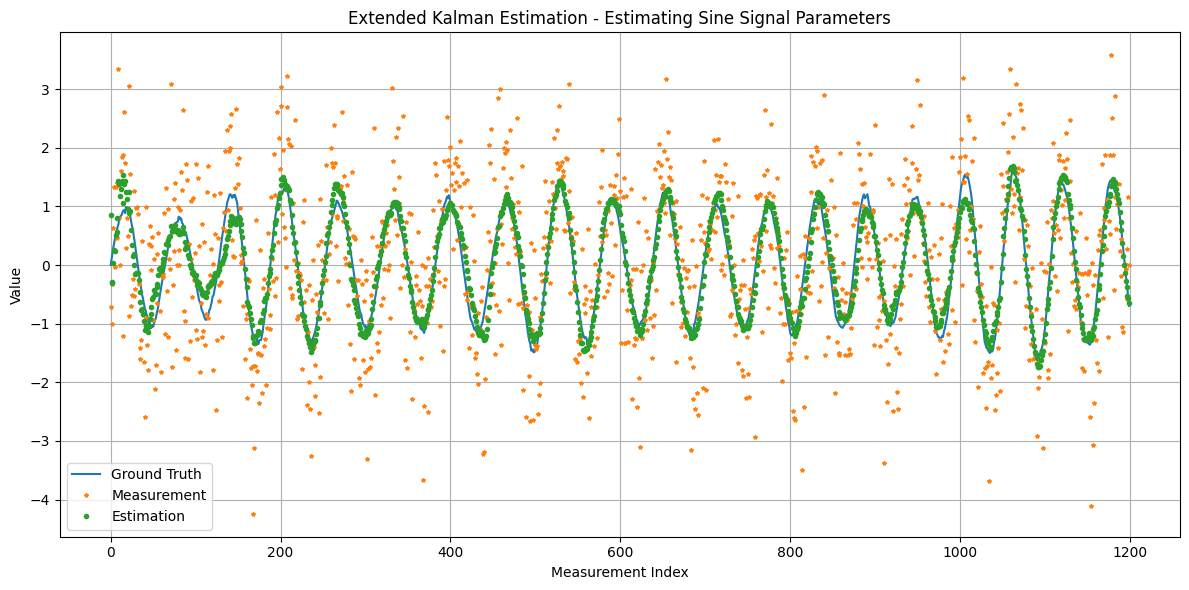

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Ground Truth')
plt.plot(z, '*', markersize=3, label='Measurement')
plt.plot(x_est[0, :] * np.sin(x_est[2, :]), 'o', markersize=3, label='Estimation')
plt.title("Extended Kalman Estimation - Estimating Sine Signal Parameters")
plt.xlabel("Measurement Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
